In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()
#kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bdallard","key":"0a6269fe3e3ff15c15a01e0dce674007"}'}

In [3]:
!ls -als ~/

total 72
8 drwx------ 1 root root 4096 Apr 13 15:16 .
4 drwxr-xr-x 1 root root 4096 Apr 13 15:13 ..
4 -rw-r--r-- 1 root root 3106 Apr  9  2018 .bashrc
4 drwx------ 1 root root 4096 Apr 13 15:16 .cache
4 drwx------ 4 root root 4096 Apr 11 20:40 .config
4 drwxr-xr-x 4 root root 4096 Apr 13 15:13 .forever
4 drwxr-xr-x 3 root root 4096 Apr 11 20:07 .gsutil
8 drwxr-xr-x 1 root root 4096 Apr 11 20:38 .ipython
4 drwx------ 2 root root 4096 Apr 11 20:38 .jupyter
4 drwxr-xr-x 2 root root 4096 Apr 13 15:16 .kaggle
4 drwxr-xr-x 2 root root 4096 Apr 13 15:13 .keras
8 drwx------ 1 root root 4096 Apr 11 20:38 .local
4 drwxr-xr-x 3 root root 4096 Apr 11 20:39 .node-gyp
4 drwxr-xr-x 4 root root 4096 Apr 11 20:38 .npm
4 -rw-r--r-- 1 root root  148 Aug 17  2015 .profile


In [0]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          27605  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          21600  
rmisra/news-headlines-dataset-for-sarcasm-detection          News Headlines Dataset For Sarcasm Detection          2MB  2018-06-09 22:14:56           2544  
iarunava/cell-images-for-detecting-malaria                   Malaria Cell Images Dataset                         337MB  2018-12-05 05:40:21           4357  
vjchoudhary7/customer-segmentation-tutorial-in-python     

In [6]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 2.88MB/s]
 92% 85.0M/92.0M [00:01<00:00, 51.4MB/s]
100% 92.0M/92.0M [00:01<00:00, 54.4MB/s]


In [7]:
!ls

example_submission.csv	fer2013.tar.gz	kaggle.json  sample_data


In [8]:
!tar -xvf fer2013.tar.gz 

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd 
import numpy as np 
from fastai import *
from fastai.vision import *

In [11]:
# load data into dataframe
df = pd.read_csv('fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [12]:
# label
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
for l in range(len(labels)):
    print(f'{l} = {labels[l]}')

0 = Angry
1 = Disgust
2 = Fear
3 = Happy
4 = Sad
5 = Surprise
6 = Neutral


In [13]:
# data types 
usages = df['Usage'].unique()
usages

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [14]:
# split
df_train = df[df['Usage'] == 'Training']
df_valid = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

n_train = len(df_train)
n_valid = len(df_valid)
n_test = len(df_test)
n = len(df)

print(f'{n_train} (Training) + {n_valid} (PublicTest) + {n_test} (PrivateTest) = {n} images')

28709 (Training) + 3589 (PublicTest) + 3589 (PrivateTest) = 35887 images


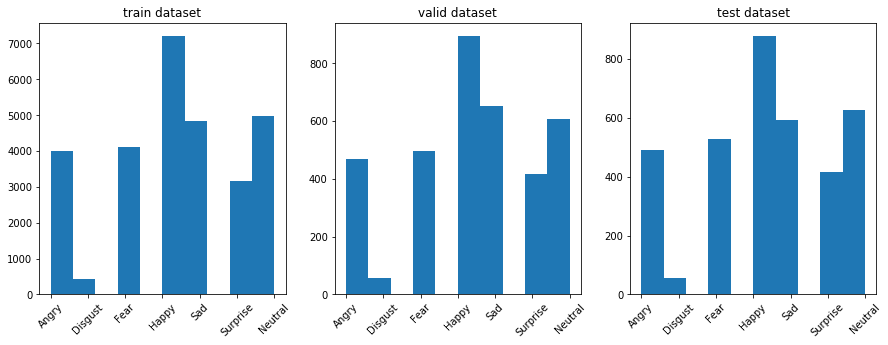

In [15]:
# histograms of train, val and test
def setup_axe(axe,df,title):
    axe.hist(df['emotion'])
    axe.set_xticks(list(range(len(labels))))
    axe.set_xticklabels(labels, rotation=45)
    axe.set_title(title)

fig, axes = plt.subplots(1,3, figsize=(15,5))
setup_axe(axes[0],df_train,'train dataset')
setup_axe(axes[1],df_valid,'valid dataset')
setup_axe(axes[2],df_test,'test dataset')
plt.show()

In [16]:
# images repartition \ emotion 
ne = df_train['emotion'].value_counts(ascending=True)
for k,v in zip(ne.keys(),ne.values):
    pct = round(v/n*100,2)
    print(f'({pct}%) {v} {labels[k]}')

(1.21%) 436 Disgust
(8.84%) 3171 Surprise
(11.13%) 3995 Angry
(11.42%) 4097 Fear
(13.46%) 4830 Sad
(13.84%) 4965 Neutral
(20.1%) 7215 Happy


In [0]:
# get image into numpy array RGB (48,48,3)
def row2image(row):
    pixels, emotion = row['pixels'], row['emotion']
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

# display image with (emotion label)
def show(img_title):
    plt.imshow(img_title[0])
    plt.title(labels[img_title[1]])

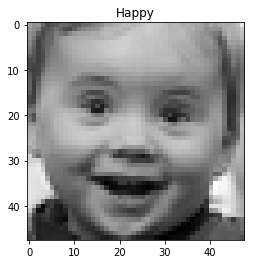

In [18]:
row = df_train.iloc[2222]
img = row2image(row)
show(img)

In [0]:
# create the folders train, val and test
Path('fer2013/train').mkdir(exist_ok=True)
Path('fer2013/valid').mkdir(exist_ok=True)
Path('fer2013/test').mkdir(exist_ok=True)

In [20]:
!ls -alsh fer2013

total 288M
4.0K drwxr-x--- 5 204241 5762 4.0K Apr 13 15:16 .
4.0K drwxr-xr-x 1 root   root 4.0K Apr 13 15:16 ..
4.0K -rw-r----- 1 204241 5762 1.4K Jul 10  2013 fer2013.bib
288M -rw------- 1 204241 5762 288M Jul 10  2013 fer2013.csv
4.0K -rw-r----- 1 204241 5762  476 Jul 10  2013 README
4.0K drwxr-xr-x 2 root   root 4.0K Apr 13 15:16 test
4.0K drwxr-xr-x 2 root   root 4.0K Apr 13 15:16 train
4.0K drwxr-xr-x 2 root   root 4.0K Apr 13 15:16 valid


In [0]:
PATH_train = 'fer2013/train'
PATH_valid = 'fer2013/valid'
PATH_test = 'fer2013/test'

In [22]:
# create train, val and test folders
for i in range(0, len(labels)):
  Path((PATH_train+'/'+labels[i])).mkdir(exist_ok=True)
  Path((PATH_valid+'/'+labels[i])).mkdir(exist_ok=True)
  Path((PATH_test+'/'+labels[i])).mkdir(exist_ok=True)
  
print("__ creation ok __")

__ creation ok __


In [23]:
!ls fer2013/test/

Angry  Disgust	Fear  Happy  Neutral  Sad  Surprise


In [0]:
# create images from pixels and save them into their corresponding subfolder of train, val and test
from tkinter import *
from tkinter import Tk, Label
from PIL import Image

def createImages(df,path):
    for e in range(len(labels)):
        df_e = df[df['emotion'] == e]
        path_e = path+'/'+labels[e]
        i=0
        for index, row in df_e.iterrows():
            img = row2image(row)
            image = Image.fromarray(img[0], 'RGB')
            fname = str(e)+'_'+str(i)+'.jpg'
            image.save(path_e+'/'+fname)
            i += 1

In [25]:
%%time
createImages(df_train,PATH_train)
createImages(df_valid,PATH_valid)
createImages(df_test,PATH_test)


CPU times: user 2min 6s, sys: 3.26 s, total: 2min 9s
Wall time: 2min 9s


In [26]:
!ls fer2013/train/Angry/

0_0.jpg     0_15.jpg	0_219.jpg   0_279.jpg	0_3399.jpg  0_401.jpg
0_1000.jpg  0_1600.jpg	0_21.jpg    0_27.jpg	0_339.jpg   0_402.jpg
0_1001.jpg  0_1601.jpg	0_2200.jpg  0_2800.jpg	0_33.jpg    0_403.jpg
0_1002.jpg  0_1602.jpg	0_2201.jpg  0_2801.jpg	0_3400.jpg  0_404.jpg
0_1003.jpg  0_1603.jpg	0_2202.jpg  0_2802.jpg	0_3401.jpg  0_405.jpg
0_1004.jpg  0_1604.jpg	0_2203.jpg  0_2803.jpg	0_3402.jpg  0_406.jpg
0_1005.jpg  0_1605.jpg	0_2204.jpg  0_2804.jpg	0_3403.jpg  0_407.jpg
0_1006.jpg  0_1606.jpg	0_2205.jpg  0_2805.jpg	0_3404.jpg  0_408.jpg
0_1007.jpg  0_1607.jpg	0_2206.jpg  0_2806.jpg	0_3405.jpg  0_409.jpg
0_1008.jpg  0_1608.jpg	0_2207.jpg  0_2807.jpg	0_3406.jpg  0_40.jpg
0_1009.jpg  0_1609.jpg	0_2208.jpg  0_2808.jpg	0_3407.jpg  0_410.jpg
0_100.jpg   0_160.jpg	0_2209.jpg  0_2809.jpg	0_3408.jpg  0_411.jpg
0_1010.jpg  0_1610.jpg	0_220.jpg   0_280.jpg	0_3409.jpg  0_412.jpg
0_1011.jpg  0_1611.jpg	0_2210.jpg  0_2810.jpg	0_340.jpg   0_413.jpg
0_1012.jpg  0_1612.jpg	0_2211.jpg  0_2811.jpg	0_3410.jpg

In [27]:
tfms = get_transforms()
data = ImageDataBunch.from_folder('fer2013/', ds_tfms=tfms, bs=32, size=299, num_workers=4)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Neutral,Neutral,Neutral,Neutral,Neutral
Path: fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Neutral,Neutral,Neutral,Neutral,Neutral
Path: fer2013;

Test: None

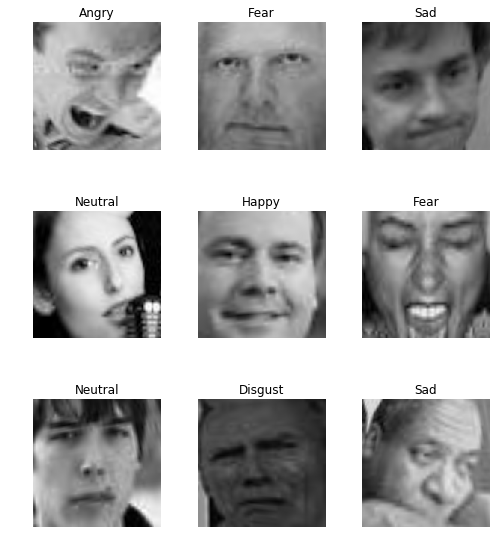

In [28]:
data.show_batch(rows=3, figsize=(7,8))

In [29]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
 7,
 28709,
 3589)

In [30]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 80286164.03it/s]


In [31]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.458946,1.340608,0.482586,15:25
1,1.304158,1.206864,0.531624,15:07


In [0]:
learn.save('fer2013-stage-1')

In [33]:
learn.load('fer2013-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Neutral,Neutral,Neutral,Neutral,Neutral
Path: fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Neutral,Neutral,Neutral,Neutral,Neutral
Path: fer2013;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [0]:
learn.unfreeze()

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


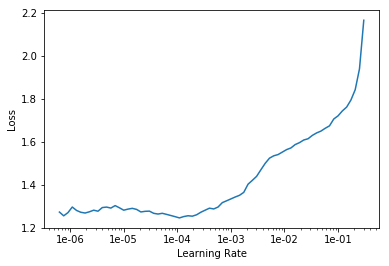

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.148006,1.112480,0.566453,20:00
1,1.106009,1.076388,0.579270,19:58


In [0]:
learn.save('fer2013-stage-2')

In [39]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.068078,1.037253,0.601839,19:59
1,1.028942,1.008142,0.608247,20:00


In [0]:
learn.save('fer2013-stage-3')

In [41]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.015560,0.992609,0.623851,20:01
1,0.942749,0.979370,0.623015,20:05


In [0]:
learn.save('fer2013-stage-4')


In [43]:
learn.load('fer2013-stage-4')

Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Neutral,Neutral,Neutral,Neutral,Neutral
Path: fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Neutral,Neutral,Neutral,Neutral,Neutral
Path: fer2013;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [44]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.936616,0.972064,0.633603,20:20
1,0.884950,0.959473,0.630816,20:20


In [0]:
learn.save('fer2013-stage-5')

In [46]:
learn.load('fer2013-stage-5')

Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Neutral,Neutral,Neutral,Neutral,Neutral
Path: fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Neutral,Neutral,Neutral,Neutral,Neutral
Path: fer2013;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

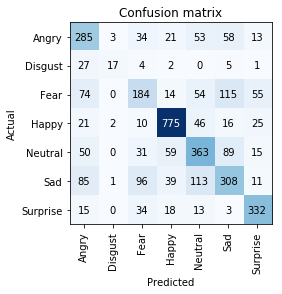

In [48]:
interp.plot_confusion_matrix()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


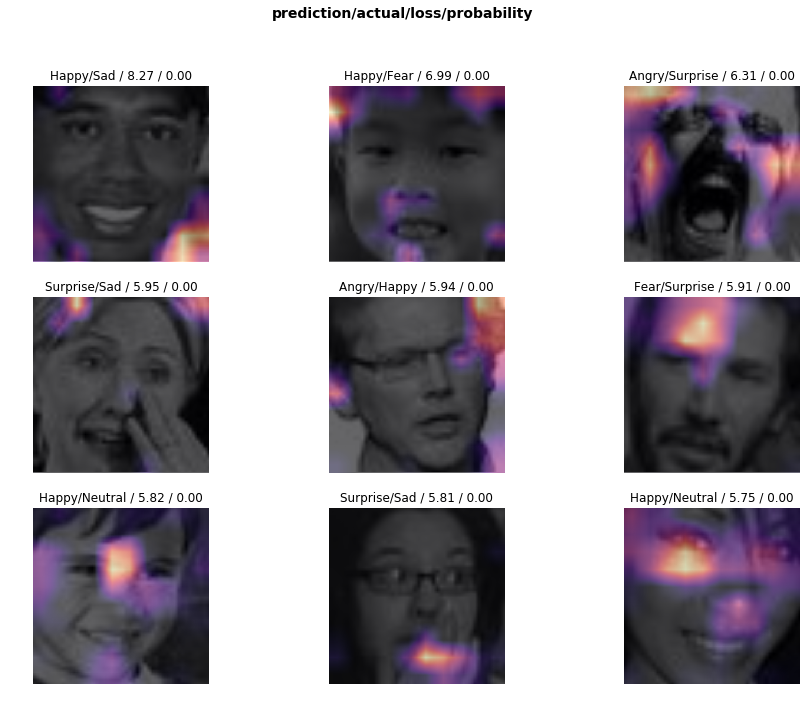

In [49]:
interp.plot_top_losses(9, figsize=(15,11))

In [50]:
learn.load('fer2013-stage-5')

Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Neutral,Neutral,Neutral,Neutral,Neutral
Path: fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Neutral,Neutral,Neutral,Neutral,Neutral
Path: fer2013;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [0]:
val_probs, val_targets = learn.get_preds()

In [0]:
val_preds = torch.argmax(val_probs,1)

In [53]:
val_acc = (val_preds == val_targets).type(torch.FloatTensor).mean().item()
print(f'valid accuracy: {round(val_acc*100,2)}%')

valid accuracy: 63.08%


In [54]:
data.classes

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

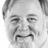

In [57]:
# get image from test folder (images arquived in subfolders)
p = Path(PATH_test+'/'+'Happy')
url = p.ls()[1]
img = open_image(url)
img

In [78]:
probs = learn.predict(img)
probs

(Category Happy,
 tensor(3),
 tensor([0.0129, 0.0094, 0.0383, 0.9258, 0.0027, 0.0050, 0.0060]))

In [79]:
values, indices = torch.max(probs[2], 0)
values

tensor(0.9258)